In [3]:
!pip install networkx==2.5
!pip install node2vec==0.4.4
!pip install gensim==4.0.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 16.2 MB/s eta 0:00:00
  Attempting uninstall: networkx
    Found existing installation: networkx 2.8.8
    Uninstalling networkx-2.8.8:
      Successfully uninstalled networkx-2.8.8


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: node2vec
    Found existing installation: node2vec 0.4.6
    Uninstalling node2vec-0.4.6:
      Successfully uninstalled node2vec-0.4.6
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.9/23.9 MB 51.1 MB/s eta 0:00:00
  Attempting uninstall: gensim
    Found existing installation: gensim 4.3.0
    Uninstalling gensim-4.3.0:
      Successfully uninstalled gensim-4.3.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
node2vec 0.4.4 requires gensim<5.0.0,>=4.1.2, but you have gensim 4.0.1 which is incompatible.


In [1]:
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from node2vec import Node2Vec as n2v
sns.set()

/usr/local/lib/python3.8/dist-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [7]:
def generate_graph_deg_dist(deg_dist, n):
    '''
    This function will generate a networkx graph G based on a degree distribution
    provided by the user.
    
    params:
        deg_dist (Dictionary) : The key will be the degree and the value is the probability
                                of a node having that degree. The probabilities must sum to
                                1
        n (Integer) : The number of nodes you want the graph to yield
                          
    example:
        G = generate_graph_deg_dist(
                deg_dist = {
                    6:0.2,
                    3:0.14,
                    8:0.35,
                    4:0.3,
                    11:0.01
                },
                n = 1000
        )
    '''
    deg = list(deg_dist.keys())
    proba = list(deg_dist.values())
    if sum(proba) == 1.:
        deg_sequence = np.random.choice(
            deg,
            n,
            proba
        )
        
        if sum(deg_sequence) % 2 != 0:
            # to ensure that the degree sequence is always even for the configuration model
            deg_sequence[1] = deg_sequence[1] + 1
        
        return nx.configuration_model(deg_sequence)
    raise ValueError("Probabilities do not equal to 1")

In [8]:
G = generate_graph_deg_dist(
        deg_dist = {
            6:0.2,
            3:0.14,
            8:0.35,
            4:0.3,
            11:0.01
        },
        n = 1000
)

print(nx.info(G))

Name: 
Type: MultiGraph
Number of nodes: 1000
Number of edges: 3197
Average degree:   6.3940


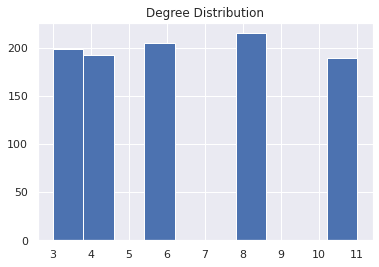

In [9]:
plt.clf()
plt.hist(list(dict(G.degree()).values()))
plt.title('Degree Distribution')
plt.show()

In [10]:
WINDOW = 1 # Node2Vec fit window
MIN_COUNT = 1 # Node2Vec min. count
BATCH_WORDS = 4 # Node2Vec batch words

g_emb = n2v(
  G,
  dimensions=16
)

mdl = g_emb.fit(
    vector_size = 16,
    window=WINDOW,
    min_count=MIN_COUNT,
    batch_words=BATCH_WORDS
)

Computing transition probabilities:   0%|          | 0/1000 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 10/10 [00:04<00:00,  2.37it/s]


In [18]:
emb_df = (
    pd.DataFrame(
        [mdl.wv.get_vector(str(n)) for n in mdl.wv.key_to_index],
        index = mdl.wv.key_to_index
    )
)
print(emb_df.shape)
emb_df.head()

(1000, 16)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
392,1.238314,-3.259057,0.952143,3.698692,2.749283,1.527890,1.228232,0.035900,-0.564279,-3.333980,-0.174155,2.243171,-1.095608,-0.230450,-1.331376,3.058906
515,3.389859,0.728191,-1.158472,-2.576545,4.889855,3.543502,1.891103,-0.863354,0.256266,-0.578756,1.415276,0.239129,-0.153287,-1.246229,0.161789,1.863557
205,1.689845,-1.128840,-0.318569,2.612801,0.807250,1.666394,2.005076,-2.584174,-0.210830,1.591558,-1.241375,-2.847491,-0.877919,-1.012062,-2.306288,4.755826
97,3.827899,1.575713,1.797532,4.335186,2.536210,-0.152467,1.279622,-1.812475,0.224613,-0.687051,-1.268439,0.764426,-2.498566,-3.431474,1.989822,-0.893313
876,0.076749,-1.327375,3.300917,1.600917,3.384822,2.749376,0.798776,0.609302,0.542304,-3.326996,1.990335,-2.274566,-3.141627,-2.040964,2.168820,-0.364138
